In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
xg = xgb.XGBClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [12]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

In [31]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=1,
        n_iter=100
    )

    random_search.fit(X, y)

    return random_search

In [14]:
def get_results(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
            'param_colsample_bytree', 'param_gamma', 'param_min_child_weight', 'param_reg_alpha', 'param_reg_lambda', 'mean_train_accuracy', 
            'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
grid_search = train_random_search(X_train, y_train, xg, param_grid)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [17]:
results = get_results(grid_search)

In [18]:
results.head(10)

,mean_fit_time,mean_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,param_min_child_weight,param_reg_alpha,param_reg_lambda,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
56,1.195796,0.018477,300,5,0.2,0.8,0.8,0.2,1,0.00,1.0,1.000000,0.871418,9,1.000000,0.781380,50,1.000000,0.697341,3,1.000000,0.726403,1
66,1.488721,0.021462,500,4,0.2,1.0,1.0,0.0,5,0.10,1.0,1.000000,0.867671,42,1.000000,0.769217,87,1.000000,0.700958,2,1.000000,0.726182,2
44,1.362882,0.018267,500,3,0.2,0.8,0.7,0.2,3,0.10,1.5,0.992175,0.866305,60,0.993507,0.764321,98,0.978002,0.702573,1,0.985554,0.725425,3
9,1.838414,0.024026,500,5,0.2,1.0,1.0,0.0,3,0.10,1.5,1.000000,0.869887,21,1.000000,0.777340,73,1.000000,0.697319,4,1.000000,0.725411,4
72,0.584828,0.015165,100,7,0.2,1.0,0.7,0.0,3,0.01,1.5,0.999924,0.874319,1,0.999955,0.796854,14,0.999770,0.689964,20,0.999862,0.723982,5
6,1.032735,0.016675,200,None,0.1,1.0,1.0,0.3,1,0.01,1.0,0.998200,0.873297,2,0.998690,0.792343,20,0.994767,0.691043,17,0.996714,0.723975,6
65,1.446667,0.018829,500,5,0.1,1.0,0.8,0.2,1,0.01,1.5,0.998314,0.871421,8,0.998712,0.784283,40,0.995159,0.692798,9,0.996924,0.723525,7
48,2.562052,0.024913,500,7,0.2,0.8,1.0,0.0,1,0.01,1.0,1.000000,0.870399,18,1.000000,0.779956,58,1.000000,0.694259,7,1.000000,0.723344,8
51,1.974597,0.024672,500,None,0.1,0.9,0.7,0.2,3,0.01,1.5,1.000000,0.871080,13,1.000000,0.783243,46,1.000000,0.692584,11,1.000000,0.723099,9
95,2.421984,0.028552,500,6,0.2,0.8,1.0,0.0,3,1.00,1.0,1.000000,0.868694,31,1.000000,0.773981,79,1.000000,0.695337,5,1.000000,0.722611,10


In [19]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
        'param_colsample_bytree', 'param_gamma', 'param_min_child_weight', 'param_reg_alpha', 'param_reg_lambda'
    ]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

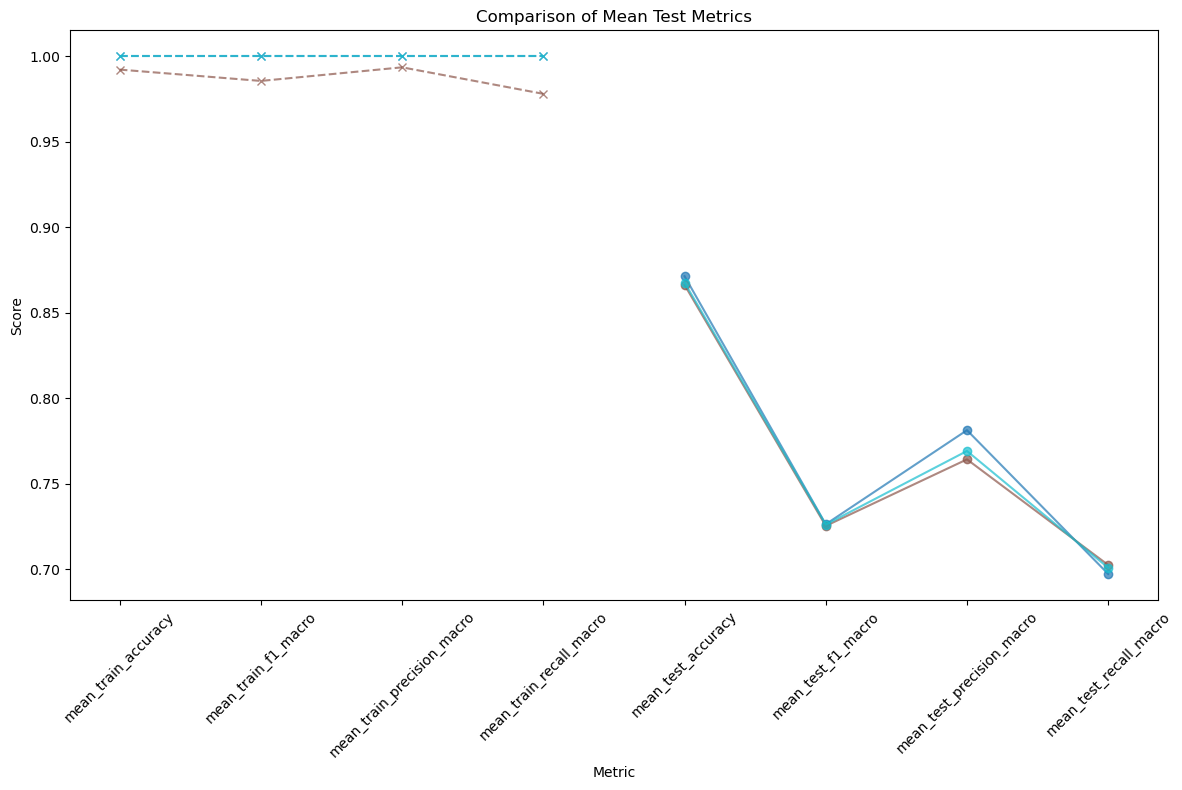

In [20]:
view_test_metrics(True, 3, results)

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [21]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [22]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('xg', xgb.XGBClassifier())
])

In [23]:
param_grid = {
    'xg__n_estimators': [100, 200, 300, 500],
    'xg__max_depth': [3, 4, 5, 6, 7, None],
    'xg__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xg__subsample': [0.7, 0.8, 0.9, 1.0],
    'xg__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'xg__gamma': [0, 0.1, 0.2, 0.3],
    'xg__min_child_weight': [1, 3, 5],
    'xg__reg_alpha': [0, 0.01, 0.1, 1],
    'xg__reg_lambda': [1, 1.5, 2]
}

In [24]:
def get_results_pipeline(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_xg__n_estimators', 'param_xg__max_depth', 'param_xg__learning_rate', 'param_xg__subsample',
            'param_xg__colsample_bytree', 'param_xg__gamma', 'param_xg__min_child_weight', 'param_xg__reg_alpha', 'param_xg__reg_lambda', 'mean_train_accuracy', 
            'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [25]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        'param_xg__n_estimators', 'param_xg__max_depth', 'param_xg__learning_rate', 'param_xg__subsample',
        'param_xg__colsample_bytree', 'param_xg__gamma', 'param_xg__min_child_weight', 'param_xg__reg_alpha', 'param_xg__reg_lambda'
    ]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [32]:
randomized_search = train_random_search(X_train, y_train, pipeline, param_grid)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [33]:
results = get_results_pipeline(randomized_search)

In [34]:
results.head(10)

,mean_fit_time,mean_score_time,param_xg__n_estimators,param_xg__max_depth,param_xg__learning_rate,param_xg__subsample,param_xg__colsample_bytree,param_xg__gamma,param_xg__min_child_weight,param_xg__reg_alpha,param_xg__reg_lambda,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
56,4.155262,0.031325,500,None,0.05,0.7,0.9,0.3,3,0.00,1.0,0.998787,0.866308,3,0.996798,0.758515,4,0.998812,0.741265,72,0.997801,0.748661,1
42,0.833038,0.017179,100,None,0.20,1.0,0.7,0.1,3,1.00,2.0,0.994732,0.861871,11,0.985587,0.749344,12,0.995646,0.746094,68,0.990530,0.747472,2
71,1.809470,0.019818,300,5,0.10,0.9,0.8,0.3,5,0.01,1.5,0.989825,0.858121,27,0.972279,0.743600,25,0.992201,0.750879,63,0.981898,0.746319,3
59,2.381007,0.022671,500,4,0.10,1.0,0.9,0.2,3,0.01,2.0,0.985277,0.855565,33,0.960472,0.739643,32,0.989155,0.755210,61,0.974078,0.746317,4
62,1.324512,0.015601,200,6,0.20,1.0,0.8,0.3,3,0.00,1.0,0.999413,0.865111,6,0.998361,0.757016,6,0.999510,0.735992,80,0.998934,0.744879,5
37,1.893157,0.019267,200,7,0.05,0.9,0.9,0.2,3,0.10,2.0,0.986774,0.857095,28,0.964714,0.740573,28,0.989590,0.749447,65,0.976606,0.744438,6
25,2.338107,0.022376,500,4,0.10,1.0,0.9,0.0,1,0.10,1.5,0.986831,0.855225,35,0.964309,0.738781,33,0.990362,0.751682,62,0.976738,0.744251,7
97,1.115819,0.019635,100,7,0.20,0.8,0.8,0.3,3,0.00,1.5,0.999261,0.861876,10,0.998088,0.750646,10,0.999234,0.739042,74,0.998659,0.743771,8
73,1.311170,0.018664,200,5,0.10,0.8,0.7,0.1,5,1.00,1.5,0.970176,0.848230,39,0.925615,0.729588,38,0.977576,0.763677,48,0.948993,0.743648,9
44,2.269896,0.022474,300,6,0.10,0.9,0.8,0.1,1,0.01,1.0,0.999981,0.866647,2,0.999943,0.760766,2,0.999989,0.729433,91,0.999966,0.742789,10


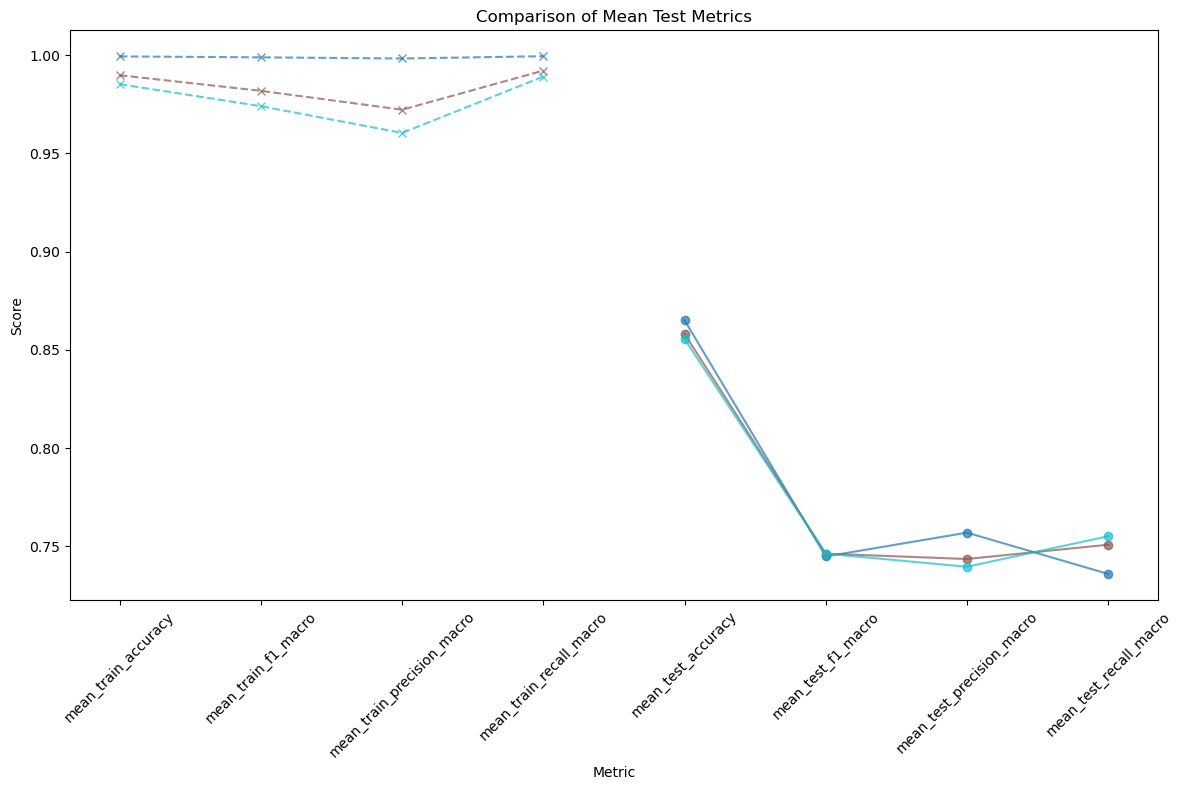

In [37]:
view_test_metrics_pipeline(True, 5, results)

In [38]:
pipeline2 = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('xg', xgb.XGBClassifier(random_state=42))
])

In [39]:
randomized_search = train_random_search(X_train, y_train, pipeline2, param_grid)
results = get_results_pipeline(randomized_search)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [40]:
results.head(10)

,mean_fit_time,mean_score_time,param_xg__n_estimators,param_xg__max_depth,param_xg__learning_rate,param_xg__subsample,param_xg__colsample_bytree,param_xg__gamma,param_xg__min_child_weight,param_xg__reg_alpha,param_xg__reg_lambda,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
1,3.991937,0.020786,300,None,0.20,0.8,0.8,0.2,3,0.01,2.0,1.000000,0.871934,3,1.000000,0.782371,4,1.000000,0.703523,14,1.000000,0.731200,1
81,2.066004,0.019508,200,4,0.10,0.9,0.8,0.2,1,1.00,2.0,0.939613,0.870913,5,0.928340,0.779259,11,0.843398,0.702919,16,0.878560,0.730236,2
14,5.961092,0.024518,500,5,0.20,0.8,0.9,0.2,1,1.00,2.0,0.999962,0.870229,11,0.999977,0.778221,13,0.999885,0.702941,15,0.999931,0.729543,3
4,8.632736,0.030730,500,7,0.20,0.9,0.7,0.0,1,0.01,2.0,1.000000,0.872787,1,1.000000,0.787939,1,1.000000,0.697374,32,1.000000,0.727869,4
98,2.174626,0.019415,300,3,0.10,0.7,1.0,0.1,5,0.00,1.5,0.927657,0.869716,13,0.907987,0.775439,20,0.815188,0.700099,22,0.852264,0.726982,5
58,5.787519,0.028984,300,None,0.05,0.9,1.0,0.2,3,0.00,2.0,0.982625,0.870910,6,0.984967,0.780947,5,0.951556,0.697899,30,0.967309,0.726868,6
73,4.430224,0.025507,500,4,0.10,0.7,0.8,0.3,5,0.00,1.0,0.990715,0.868527,26,0.992480,0.772190,34,0.973712,0.700620,19,0.982799,0.726674,7
15,6.962364,0.027926,500,None,0.20,0.8,0.9,0.1,1,1.00,2.0,1.000000,0.869032,23,1.000000,0.772945,31,1.000000,0.700110,21,1.000000,0.726629,8
26,3.170424,0.020365,200,5,0.05,0.7,0.8,0.2,1,0.00,2.0,0.933322,0.869036,21,0.915193,0.773584,26,0.830953,0.699295,24,0.865595,0.726077,9
66,4.030068,0.020459,300,7,0.20,1.0,0.8,0.1,1,1.00,2.0,1.000000,0.871079,4,1.000000,0.780824,6,1.000000,0.696760,39,1.000000,0.726063,10


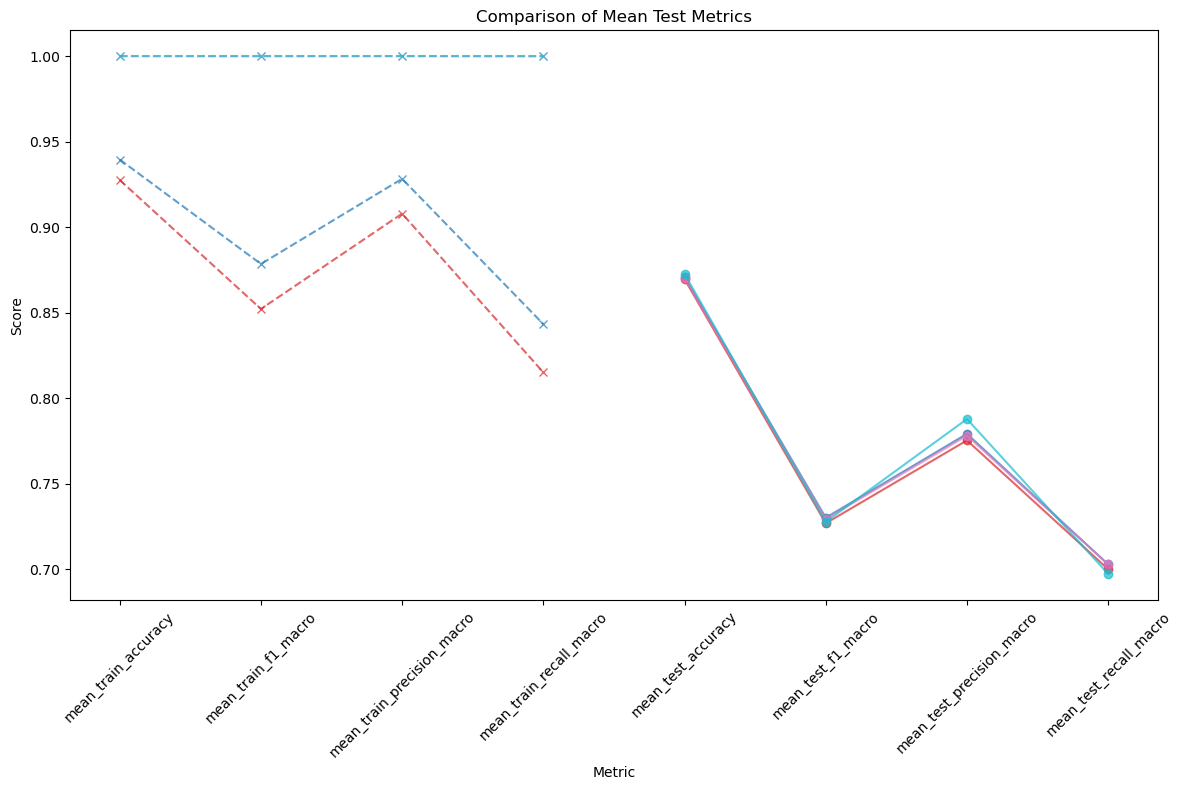

In [43]:
view_test_metrics_pipeline(True, 5, results)

Retreinando o modelo com melhor configuração

In [54]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('xg', xgb.XGBClassifier(
        n_estimators=500,
        max_depth=None,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.9,
        gamma=0.3,
        min_child_weight=3,
        reg_alpha=0.00,
        reg_lambda=1.0,
        random_state=42
    ))
])

In [55]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

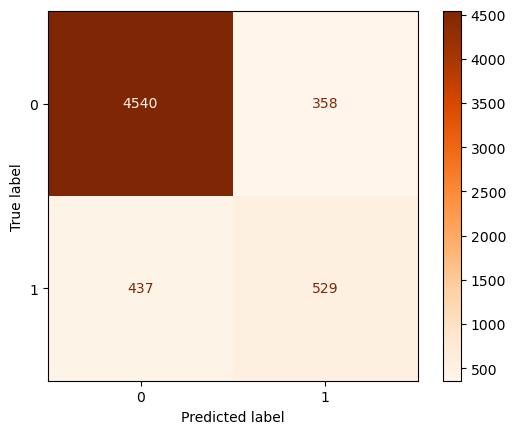

In [56]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [57]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9122    0.9269    0.9195      4898
           1     0.5964    0.5476    0.5710       966

    accuracy                         0.8644      5864
   macro avg     0.7543    0.7373    0.7452      5864
weighted avg     0.8602    0.8644    0.8621      5864



In [58]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversampler', RandomOverSampler(random_state=42)),
                ('xg',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [59]:
xg = pipeline.named_steps['xg']

In [60]:
col_names = list(joblib.load('data/col_names.pkl'))

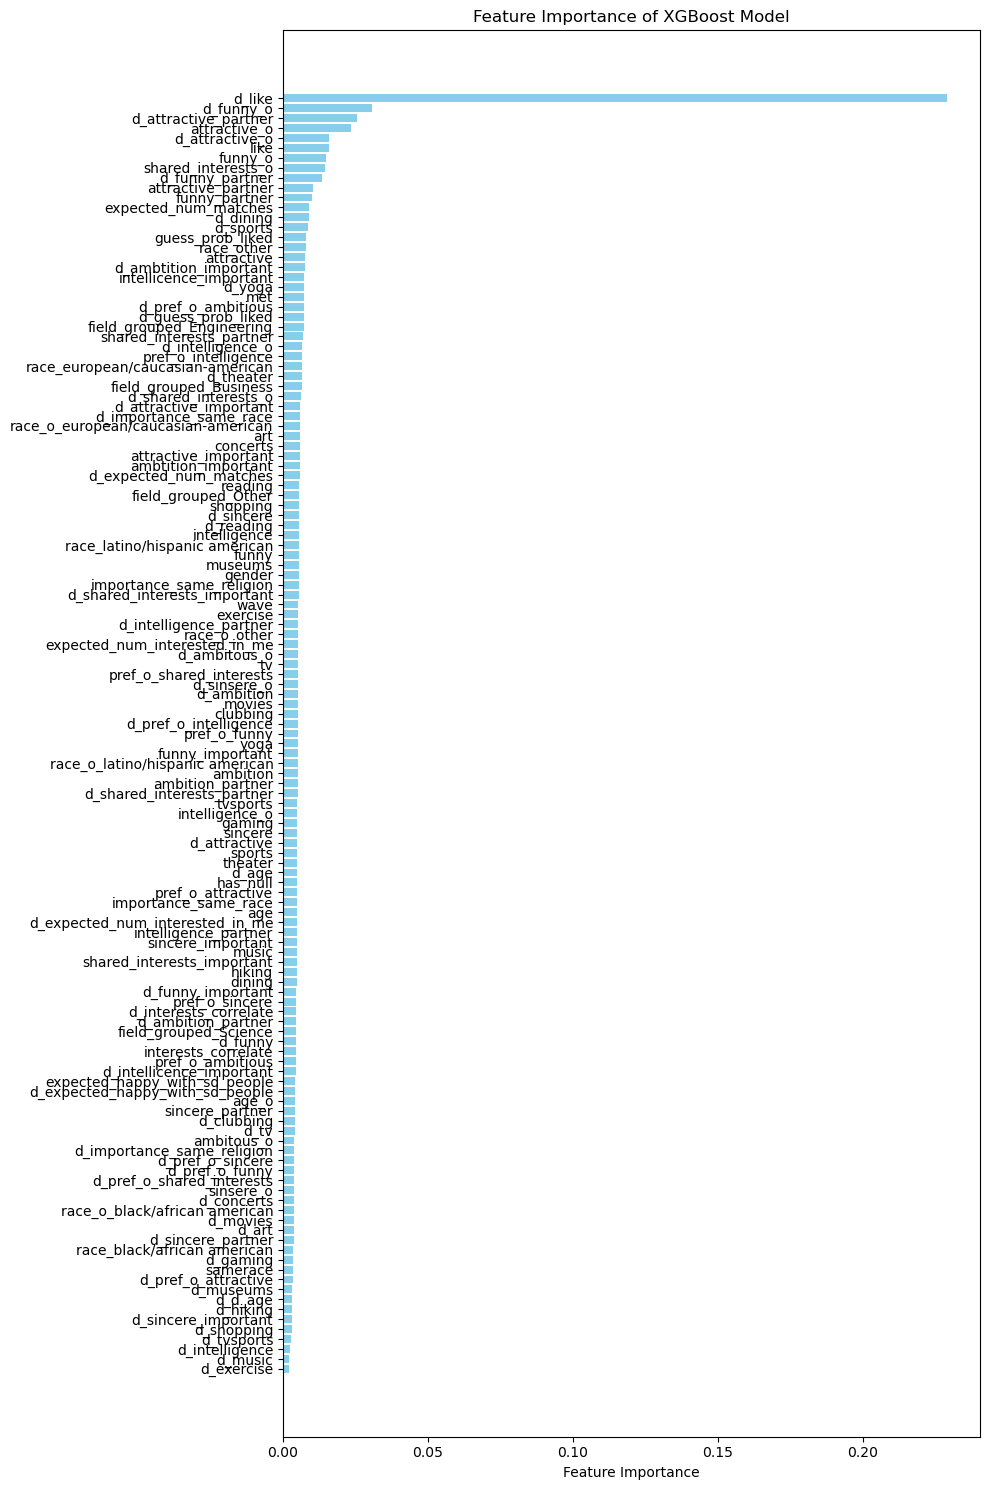

In [62]:
importances = xg.feature_importances_.ravel().reshape(1, -1)
feature_importance = pd.DataFrame(data=importances, columns=col_names)

importance_series = feature_importance.iloc[0]
importance_series_sorted = importance_series.sort_values(ascending=True)

plt.figure(figsize=(10, 15))
plt.barh(importance_series_sorted.index, importance_series_sorted.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of XGBoost Model')
plt.tight_layout()
plt.show()

In [63]:
joblib.dump(xg, 'models/xg.pkl')

['models/xg.pkl']